In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os


from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Convolution2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, AveragePooling2D, UpSampling2D, Activation, Flatten, Add, ReLU
from tensorflow.keras import layers

2022-11-16 01:38:50.277904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 01:38:50.396741: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 01:38:50.940180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nkspartan/miniconda3/envs/tf-gpu/lib/
2022-11-16 01:38:50.940251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfe

In [2]:
# para que tf no use mucha vram

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2022-11-16 01:38:51.887316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 01:38:51.891938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 01:38:51.892142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Read dataset

In [3]:
IMAGE_SIZE = 320
BATCH_SIZE = 16
SEED = 0

In [4]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
output_shape = IMAGE_SIZE * IMAGE_SIZE * 3

In [5]:
from glob import glob

def make_dataset(path, batch_size, img_size, seed=None):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        #image = tf.image.rgb_to_grayscale(image)
        #image = tf.image.grayscale_to_rgb(image)
        image = tf.image.resize(image, [img_size, img_size])

        image = tf.cast(image, tf.float32)
        image = image / 255

        return image
    
    def parse_mask(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_png(image, channels=1)
        #image = tf.image.rgb_to_grayscale(image)
        #image = tf.image.grayscale_to_rgb(image)
        image = tf.image.resize(image, [img_size, img_size])

        image = tf.cast(image, tf.float32)
        #image = tf.reshape(image, [img_size * img_size * 1])

        return image

    def configure_for_performance(ds):
        # Shuffle dataset every time, even if its divided by years
        ds = ds.shuffle(buffer_size=100)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        #ds = ds.prefetch(buffer_size=10)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        return ds

    path_image = "/images"
    path_mask = "/masks"

    filenames_image = [str(i) for i in glob(path + path_image + '/*')]
    filenames_mask = [str(i) for i in glob(path + path_mask + '/*')]

    filenames_image.sort()
    filenames_mask.sort()

    #print(filenames_image)
    #print(filenames_mask)

    filenames_image_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(filenames_image, dtype=tf.string))
    filenames_mask_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(filenames_mask, dtype=tf.string))

    #print(filenames_image_ds)

    images_ds = filenames_image_ds.map(lambda x: parse_image(x), num_parallel_calls=8)
    masks_ds = filenames_mask_ds.map(lambda x: parse_mask(x), num_parallel_calls=8)

    # create tensorflow dataset of images and values (train, val, test)
    images_masks_ds = tf.data.Dataset.zip((images_ds, masks_ds))
    images_masks_ds = configure_for_performance(images_masks_ds)

    return images_masks_ds, len(filenames_image)

In [6]:
train_path = 'dataset/dataset_v1/train'
val_path = 'dataset/dataset_v1/validation'
test_path = 'dataset/dataset_v1/test'

In [7]:
train_ds, len_train = make_dataset(train_path, BATCH_SIZE, IMAGE_SIZE, 0)
val_ds, len_val = make_dataset(val_path, BATCH_SIZE, IMAGE_SIZE, 0)
test_ds, len_test = make_dataset(test_path, BATCH_SIZE, IMAGE_SIZE, 0)

2022-11-16 01:38:52.041469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 01:38:52.042089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 01:38:52.042288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 01:38:52.042432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [8]:
print(len_train * 2)
print(len_val * 2)
print(len_test * 2)

1578
456
222


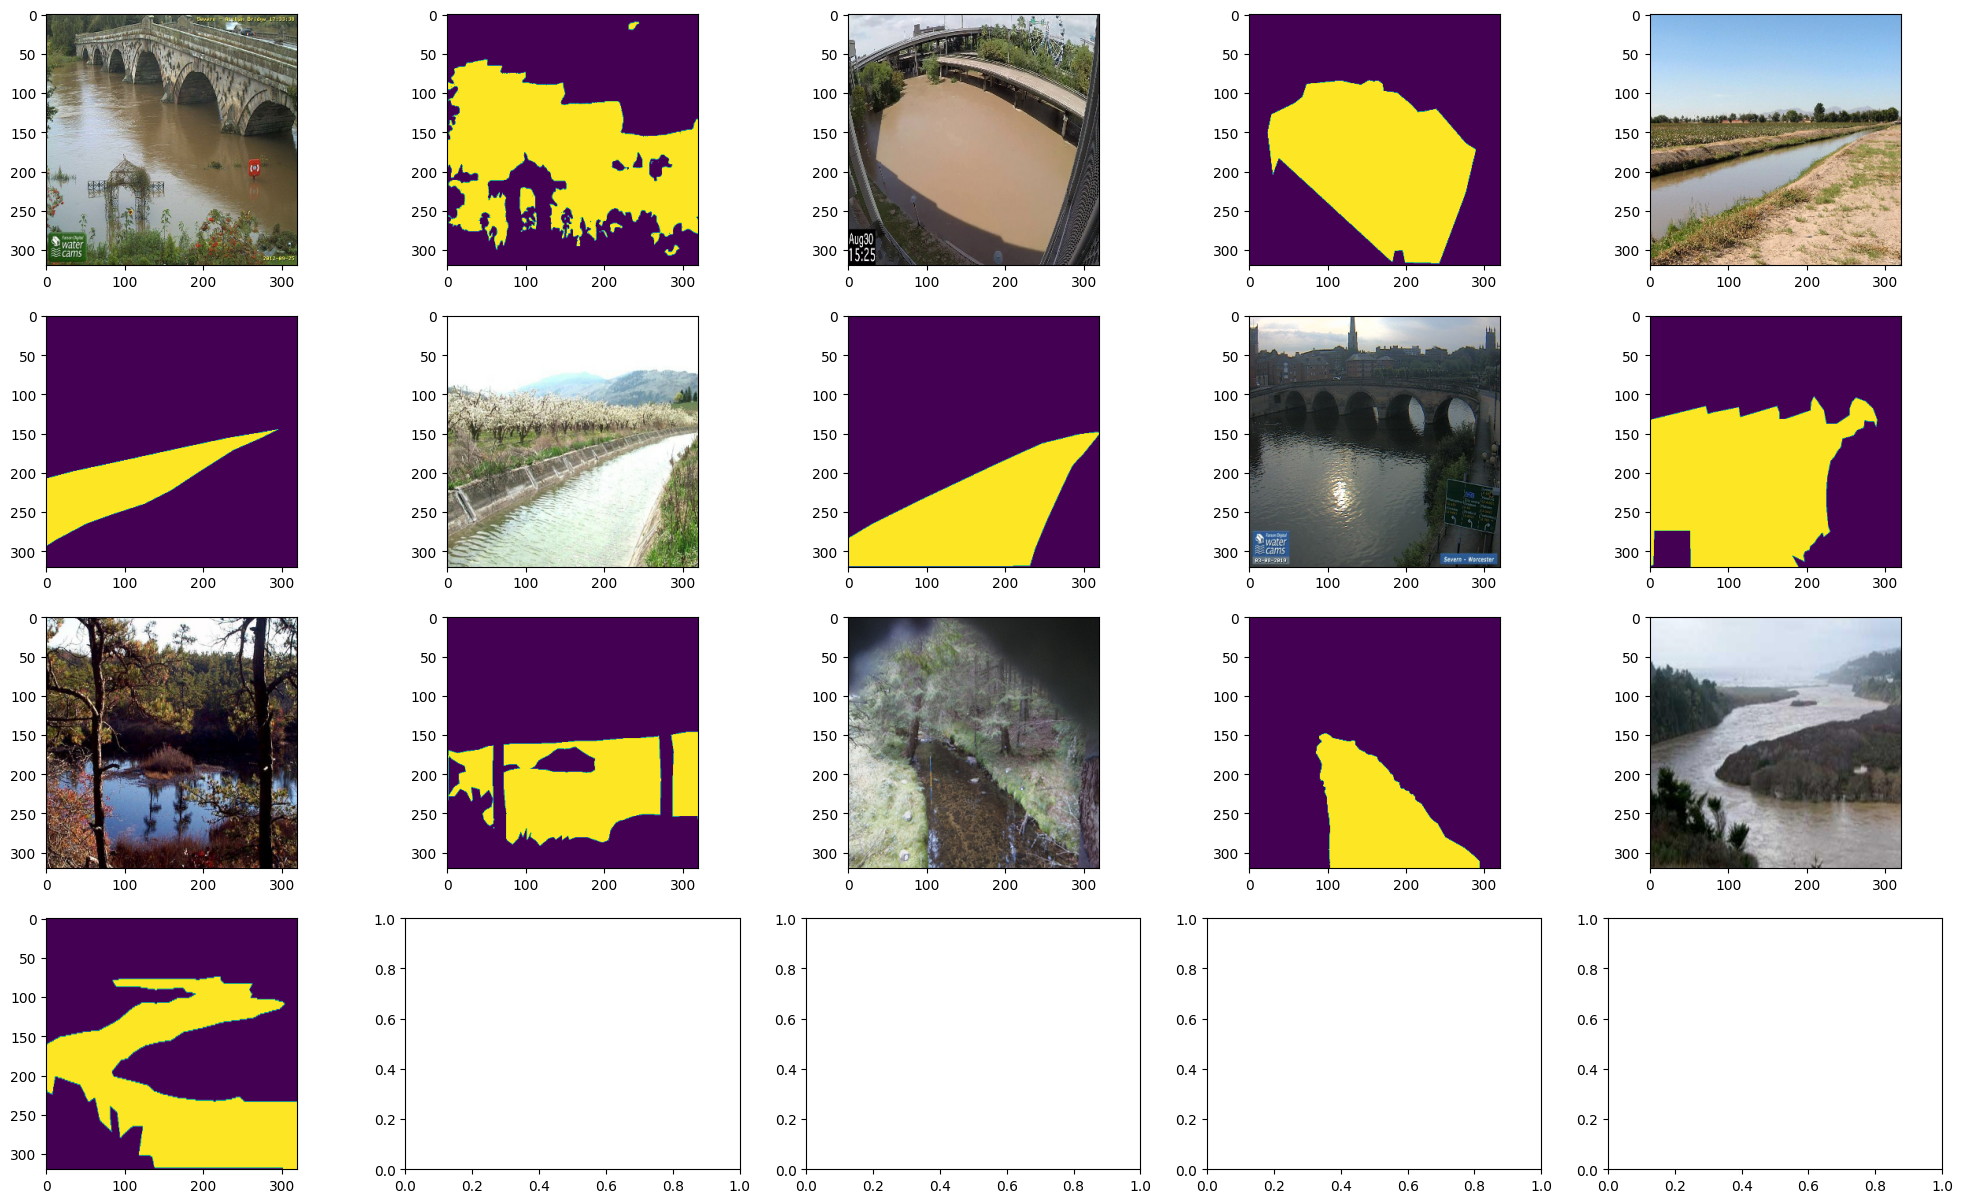

In [9]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 15))

for image, mask in val_ds.take(1):
    images = image[:10]
    masks = mask[:10]
    images_and_masks = []

    for i, j in zip(images, masks):
        images_and_masks.append(i)
        images_and_masks.append(j)

    for img_mask, ax in zip(images_and_masks, ax.flatten()):
        img_mask = img_mask.numpy()
        ax.imshow(img_mask)
    
    
plt.show()


## Create Model

### PSPNet

In [10]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Convolution2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Convolution2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Convolution2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Convolution2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    """base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    base = conv_block(base,[64,64,128],'2')
    # block_3
    base = conv_block(base,[64,64,256],'3')
    # block_4
    base = conv_block(base,[64,64,512],'4')"""

    base = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    )
    
    for layer in base.layers:
        layer.trainable = False

    base = base(input_layer)

    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,512))(red)
    red = Convolution2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=512,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Convolution2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Convolution2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Convolution2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)

    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Convolution2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid', name='last_conv_relu')(X)
    X = Flatten(name='last_conv_flatten')(X)
    return X

### U-Net model

In [11]:
def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=(img_size, img_size) + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 6, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 1, activation="softmax", padding="same")(x)
    #outputs = layers.Flatten()(outputs)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

### Pre-trained segmentation model

In [12]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [13]:
def get_pre_trained_model():
    BACKBONE = 'resnet34'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    model = sm.Unet(BACKBONE, classes=1, activation='sigmoid', encoder_weights='imagenet')

    return model

## Train model

In [14]:
#input_layer = tf.keras.Input(shape=input_shape, name='input')
#model = get_model(IMAGE_SIZE, 1)
model = get_pre_trained_model()
#model = tf.keras.Model(inputs=input_layer,outputs=output_layer)

2022-11-16 01:39:05.029370: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25MiB (rounded to 2359296)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-16 01:39:05.029412: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2022-11-16 01:39:05.029422: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 62, Chunks in use: 62. 15.5KiB allocated for chunks. 15.5KiB in use in bin. 8.2KiB client-requested in use in bin.
2022-11-16 01:39:05.029428: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 32, Chunks in use: 32. 16.0KiB allocated for chunks. 16.0KiB in use in bin. 16.0KiB client-requested in use in bin.
2022-11-16 01:39:05.029434: I tenso

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

## Train model

In [ ]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_segmentation_best_weights.hdf5",
                               monitor='val_loss',
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
#model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=adam, loss=total_loss, metrics=metrics)

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=60, batch_size=BATCH_SIZE, steps_per_epoch=np.ceil(len_train / BATCH_SIZE), validation_steps=np.ceil(len_val / BATCH_SIZE), callbacks=[tensorboard_callback, es_callback, checkpoint_callback])

Epoch 1/60


2022-11-16 00:05:44.771200: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-16 00:05:45.256052: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-16 00:05:45.256926: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-16 00:05:45.256943: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-16 00:05:45.257654: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-16 00:05:45.257695: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


50/50 [==============================] - ETA: 0s - loss: 0.9009 - iou_score: 0.4919

2022-11-16 00:06:06.038207: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2022-11-16 00:06:06.254707: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2022-11-16 00:06:06.441023: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2022-11-16 00:06:06.609485: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2022-11-16 00:06:06.787395: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 31773.57031, saving model to model_weights/20221116-000540_segmentation_best_weights.hdf5
50/50 [==============================] - 27s 377ms/step - loss: 0.9009 - iou_score: 0.4919 - val_loss: 31773.5703 - val_iou_score: 0.3018
Epoch 2/60
50/50 [==============================] - ETA: 0s - loss: 0.7246 - iou_score: 0.5896
Epoch 2: val_loss improved from 31773.57031 to 8548.93945, saving model to model_weights/20221116-000540_segmentation_best_weights.hdf5
50/50 [==============================] - 15s 301ms/step - loss: 0.7246 - iou_score: 0.5896 - val_loss: 8548.9395 - val_iou_score: 0.2464
Epoch 3/60
50/50 [==============================] - ETA: 0s - loss: 0.6824 - iou_score: 0.6199
Epoch 3: val_loss did not improve from 8548.93945
50/50 [==============================] - 15s 297ms/step - loss: 0.6824 - iou_score: 0.6199 - val_loss: 100116.1250 - val_iou_score: 0.2878
Epoch 4/60
50/50 [==============================] - ETA: 0s - loss: 0.7022 - iou

In [ ]:
print(date_actual)

20221116-000540


In [ ]:
#best_model = tf.keras.models.load_model(f'model_weights/{date_actual}_segmentation_best_weights.hdf5')

best_model = model
best_model.load_weights(
    f'model_weights/{date_actual}_segmentation_best_weights.hdf5')


In [ ]:
def evaluate_model(model, test_values, steps):
  score = model.evaluate(test_values, steps=steps)
  return score

In [ ]:
test_loss, test_accuracy = evaluate_model(best_model, test_ds, steps=np.ceil(len_test / BATCH_SIZE))

7/7 [==============================] - 2s 214ms/step - loss: 104.1524 - iou_score: 0.2659


1/1 [==============================] - 1s 522ms/step


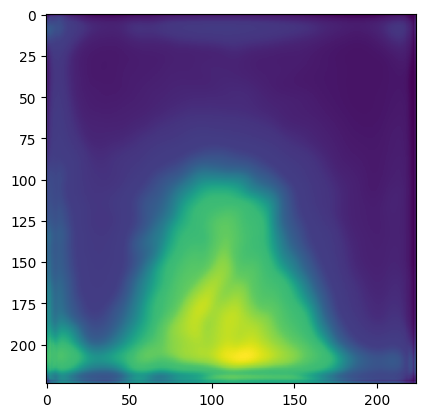

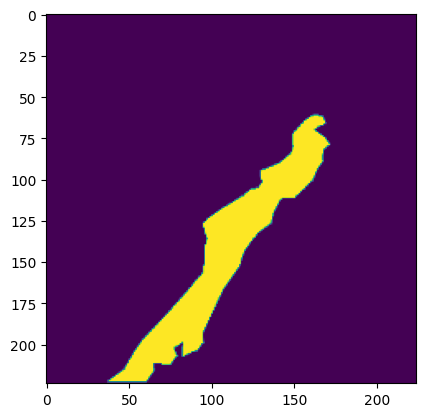

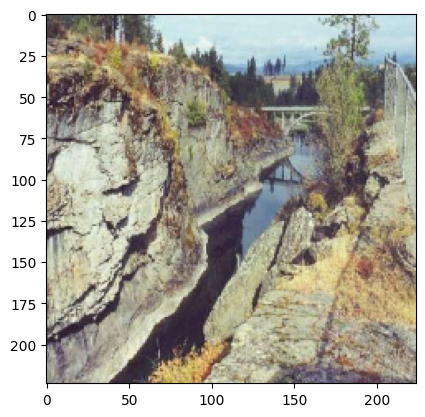

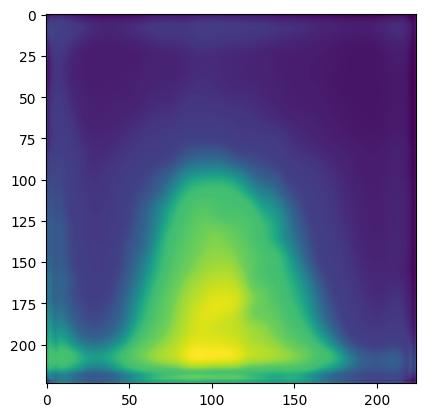

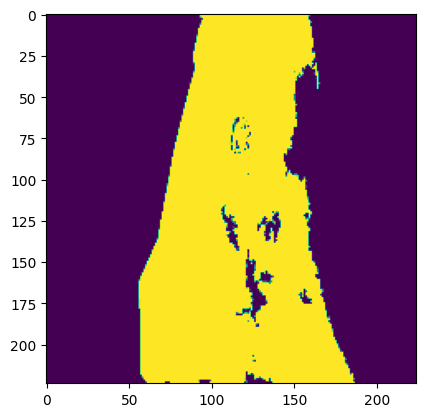

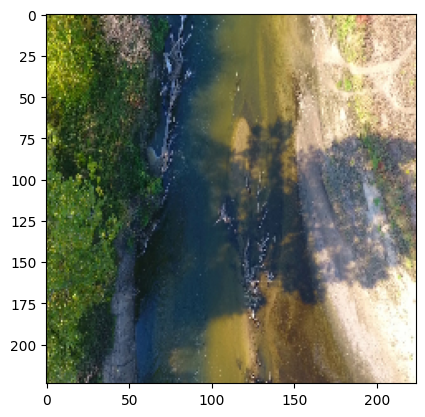

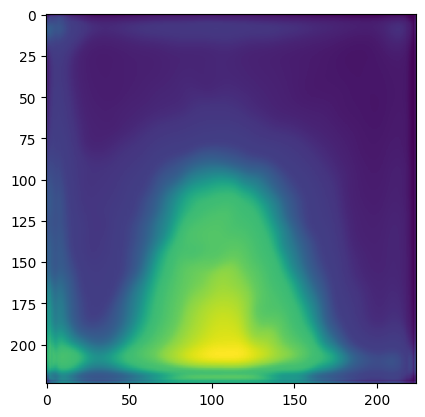

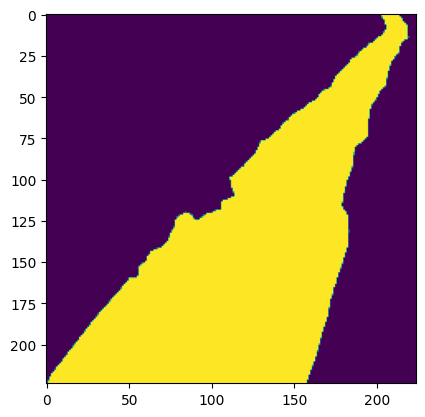

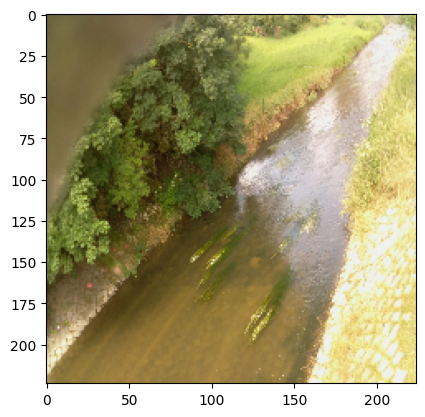

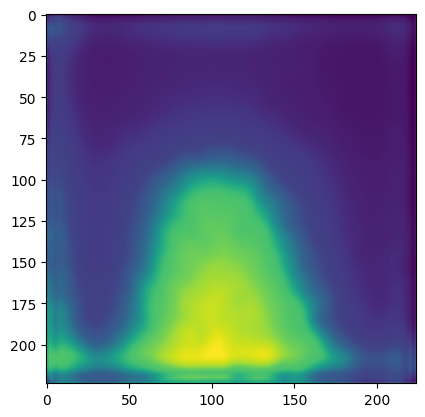

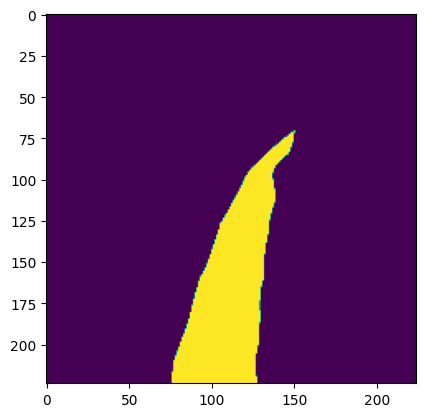

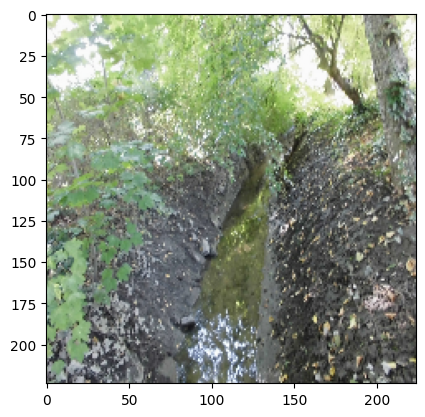

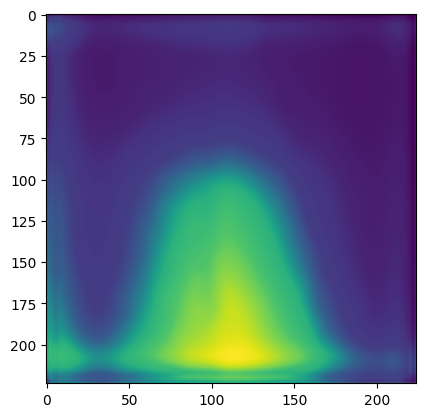

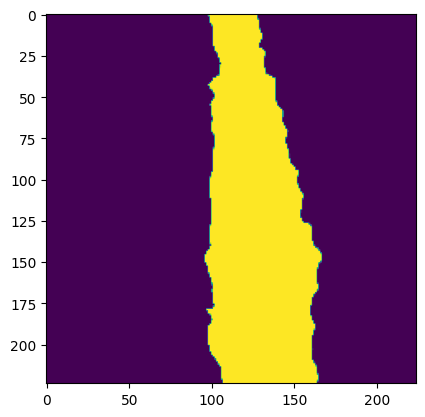

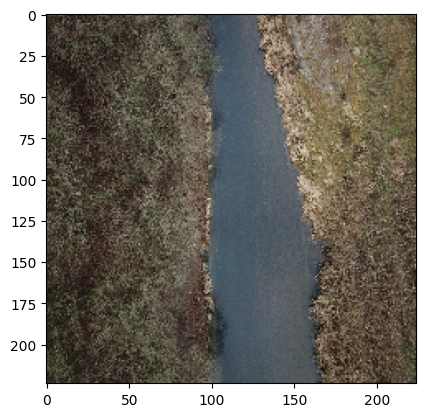

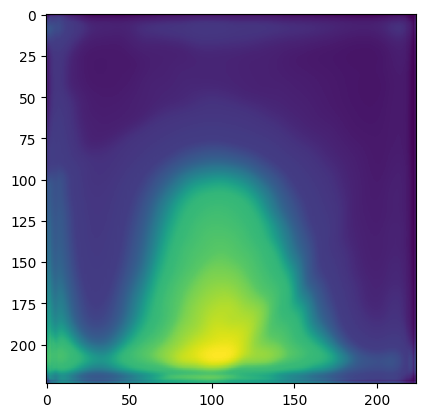

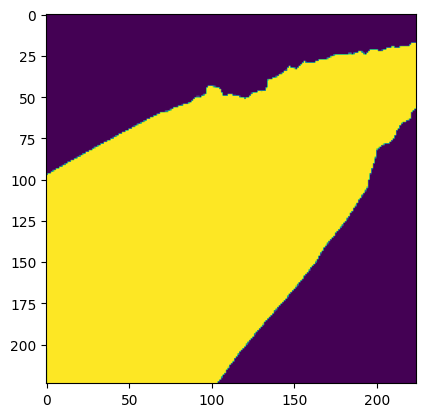

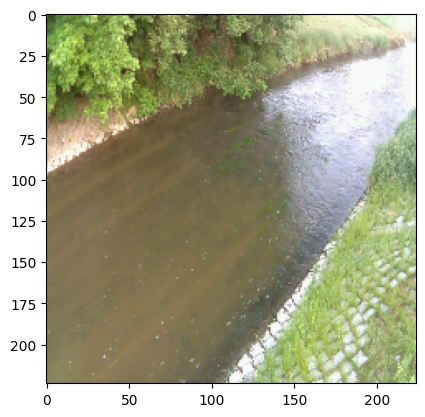

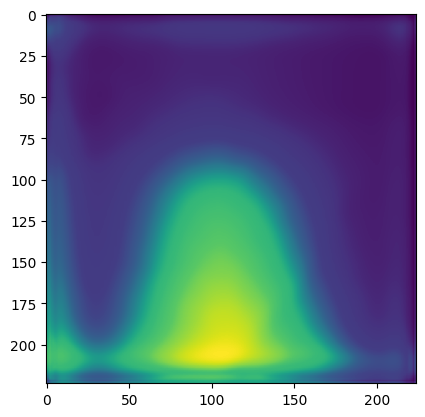

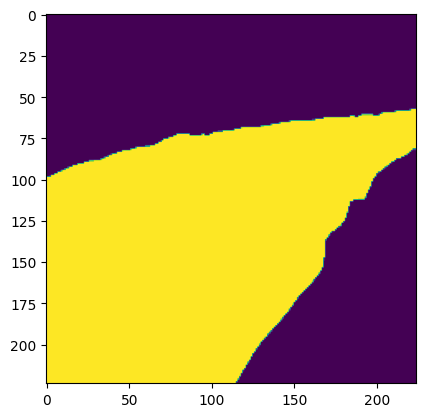

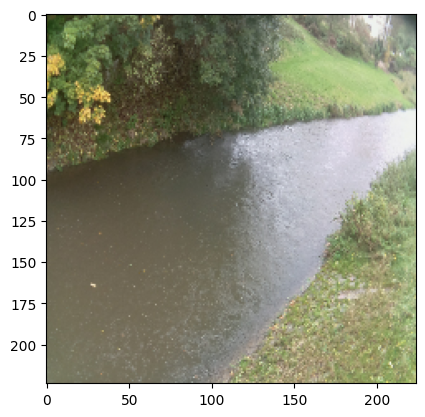

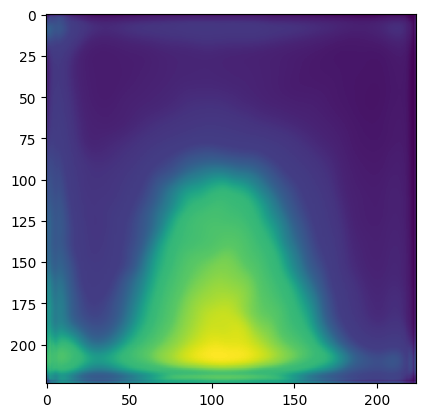

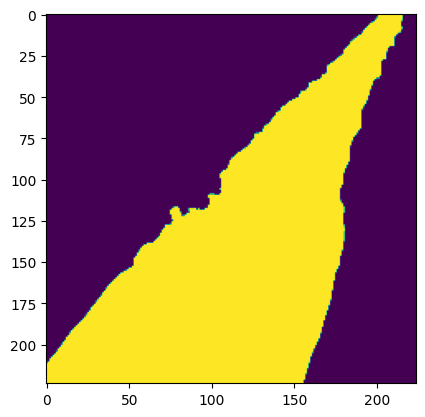

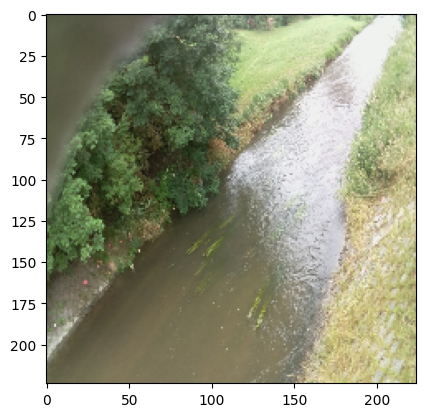

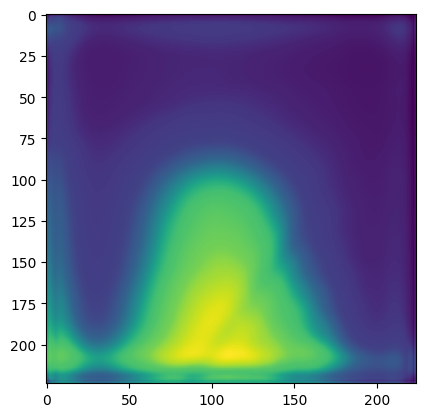

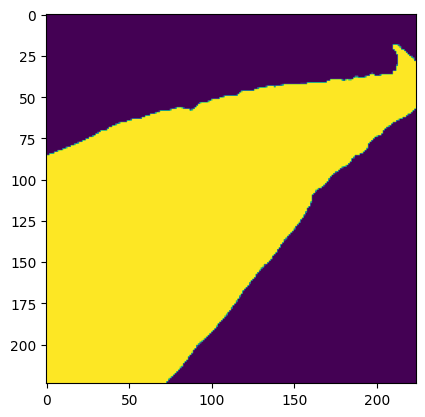

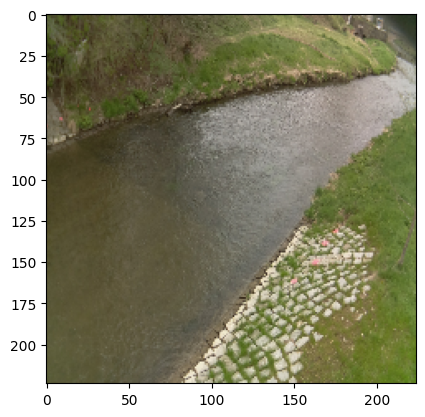

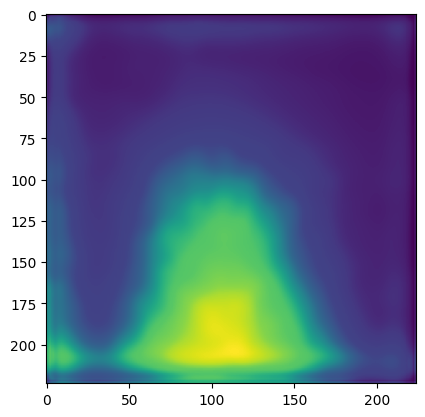

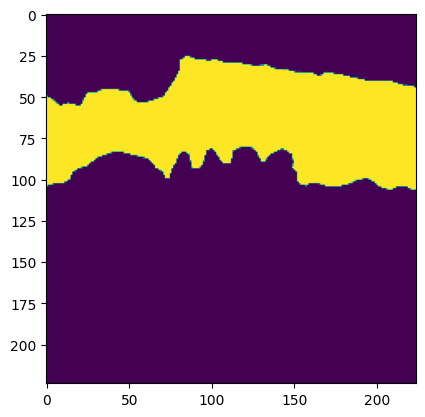

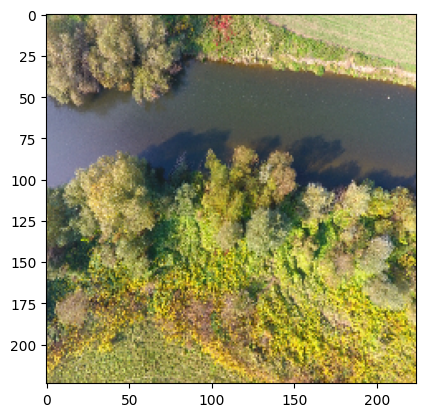

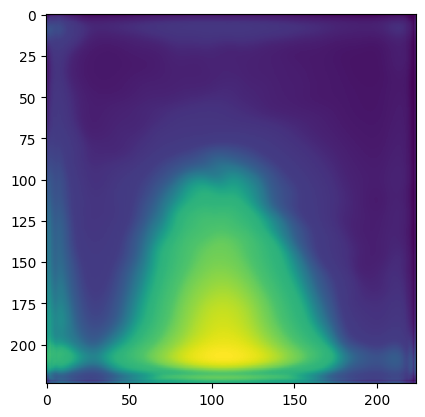

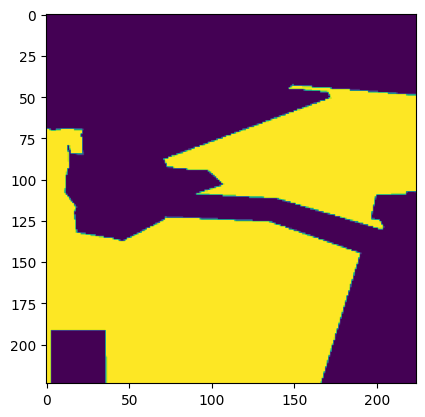

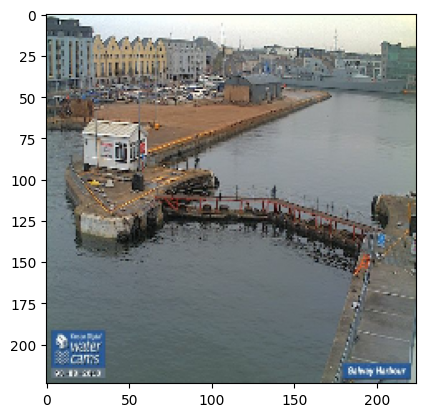

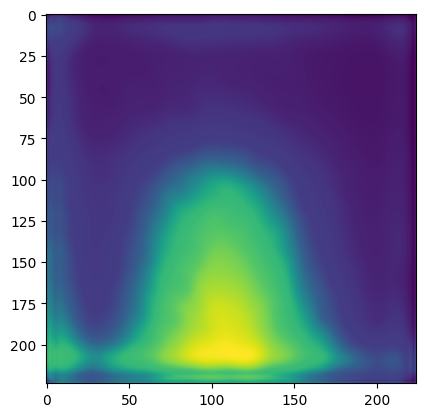

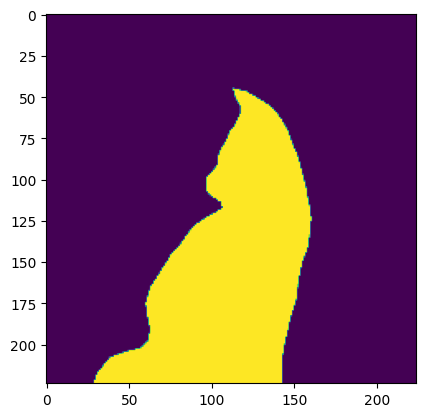

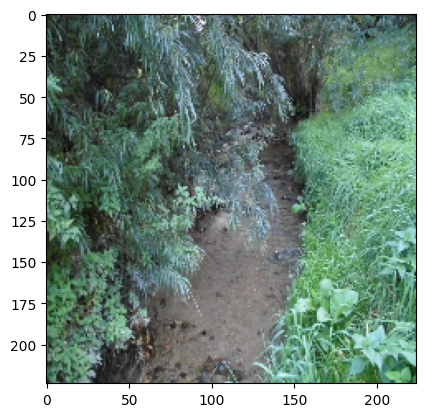

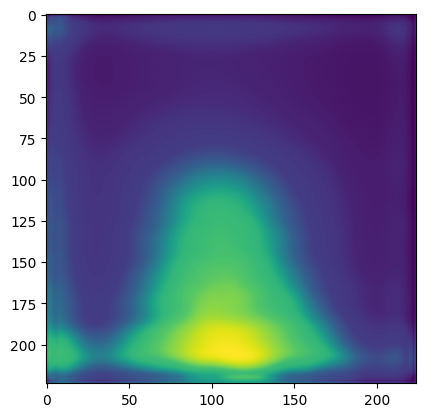

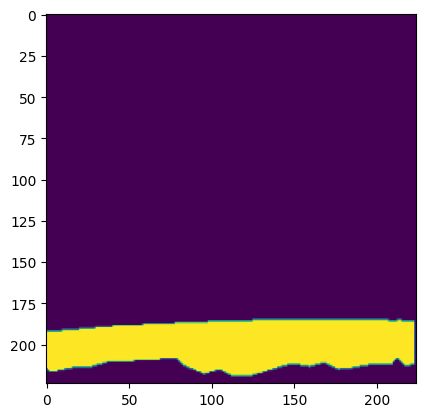

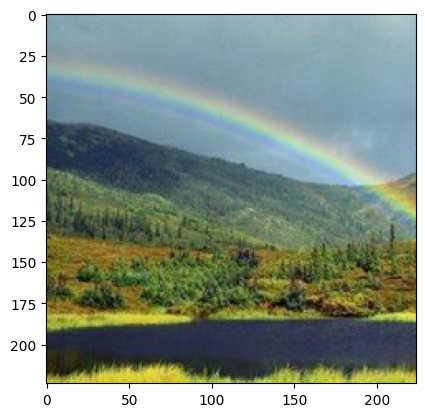

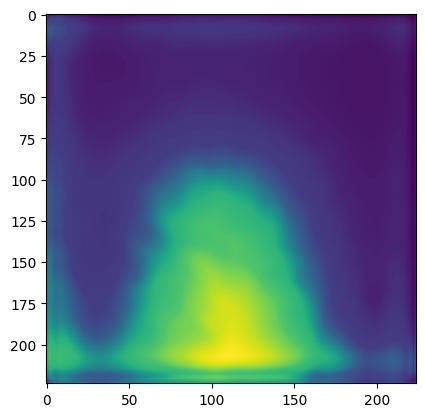

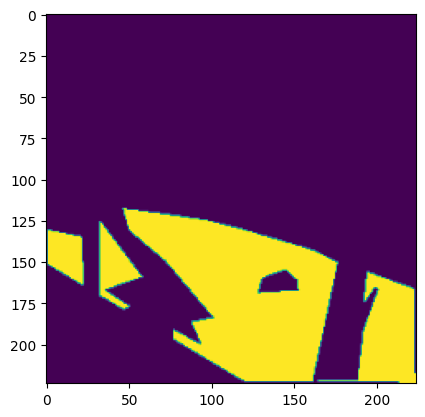

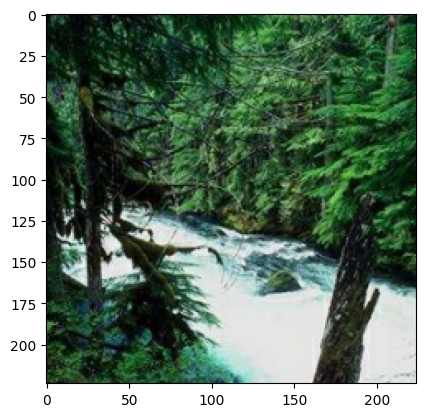

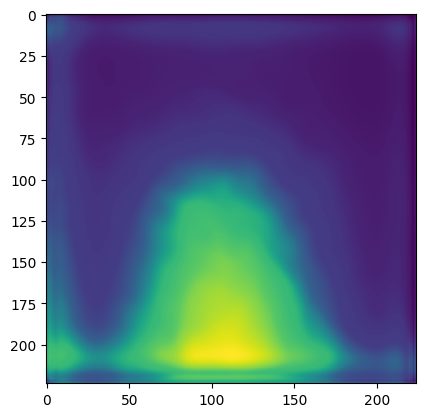

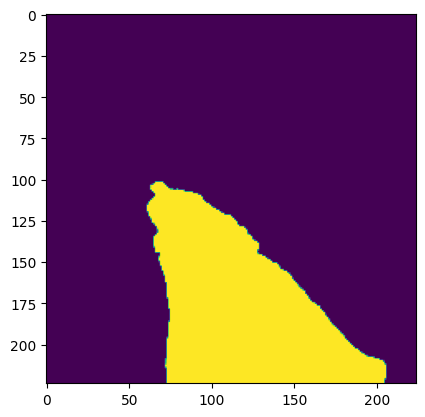

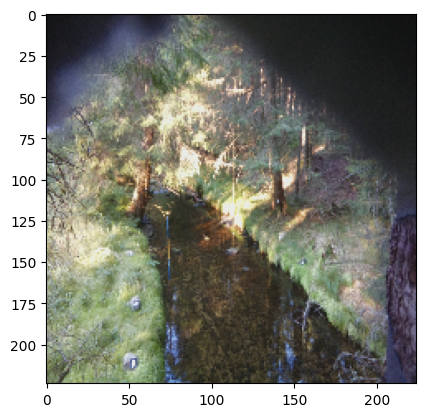

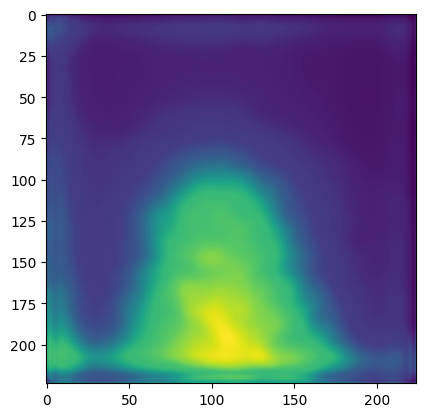

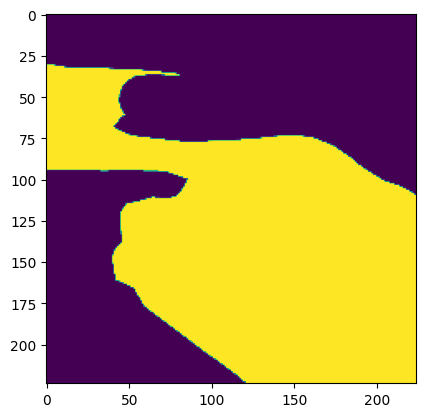

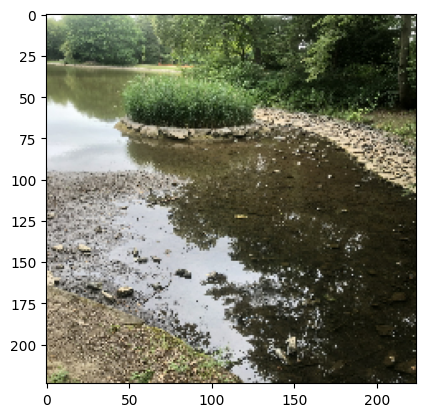

In [ ]:
for image, mask in test_ds.take(1):
    predictions = best_model.predict(x=image)
    
    for i, j, k in zip(predictions, mask, image):
        j = j.numpy()
        i = np.reshape(i, (IMAGE_SIZE, IMAGE_SIZE, 1))
        
        plt.imshow(i)
        plt.show()
        plt.imshow(j)
        plt.show()
        plt.imshow(k)
        plt.show()
    
    plt.show()